In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
import plotly.express as px
import matplotlib.pyplot as plt
import scipy.stats as sts
import math

## 1. Load data

In [2]:
data = pd.read_feather('USD_TOM_trades_Micex_02_10.feather')

In [3]:
data.dtypes

Time              datetime64[ns]
PRICE                    float64
SIZE                       int32
AGGRESSOR_SIDE            object
TRADE_VALUE              float64
dtype: object

In [4]:
data[:5]

,Time,PRICE,SIZE,AGGRESSOR_SIDE,TRADE_VALUE
0,2021-02-01 10:00:00.271880,75.5975,100,B,7559750.0
1,2021-02-01 10:00:00.271880,75.6000,500,B,37800000.0
2,2021-02-01 10:00:00.271880,75.6700,63,B,4767210.0
3,2021-02-01 10:00:00.304507,75.6625,10,B,756625.0
4,2021-02-01 10:00:00.346729,75.6575,3,B,226972.5


Aggregate records with the same timestamp. Such trades are caused by one market order.

In [5]:
market_orders = data.groupby(by=['Time', 'AGGRESSOR_SIDE'], as_index=False).agg({'PRICE': ['min', 'max'], 'SIZE': 'sum', })

In [6]:
market_orders[:5]

Time AGGRESSOR_SIDE    PRICE          SIZE
                                                 min      max  sum
0 2021-02-01 10:00:00.271880              B  75.5975  75.6700  663
1 2021-02-01 10:00:00.304507              B  75.6625  75.6625   10
2 2021-02-01 10:00:00.346729              B  75.6575  75.6575    3
3 2021-02-01 10:00:00.360369              S  75.6025  75.6025   20
4 2021-02-01 10:00:00.377261              S  75.6025  75.6025    4

In [7]:
# I divide orders by volume into 5 categories
vol_cats = {0: -1, 100: 0, 200: 1, 500: 2, 1000: 3, 5000: 4}

In [8]:
# Add features
market_orders['DOW'] = market_orders['Time'].map(lambda d: d.isoweekday())  # day of week

In [9]:
market_orders['H'] = market_orders['Time'].map(lambda d: d.hour)  # hour

In [10]:
market_orders['M'] = market_orders['Time'].map(lambda d: d.minute)  # minute

In [11]:
market_orders['VolCat'] = market_orders['SIZE', 'sum'].map(lambda x: vol_cats[min(vol_cats.keys(), key=lambda z: z-x if x<z else math.inf)])

In [12]:
market_orders['Volume'] = market_orders['SIZE', 'sum']  # replace multicolumn with simple column
market_orders['PRICE_MIN'] = market_orders['PRICE', 'min']
market_orders['PRICE_MAX'] = market_orders['PRICE', 'max']

market_orders.drop(columns=['SIZE','PRICE'], inplace=True)

/home/sharpra/miniconda3/lib/python3.9/site-packages/pandas/core/generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [13]:
market_orders[:5]

,Time,AGGRESSOR_SIDE,DOW,H,M,VolCat,Volume,PRICE_MIN,PRICE_MAX
,,,,,,,,,
0,2021-02-01 10:00:00.271880,B,1,10,0,3,663,75.5975,75.6700
1,2021-02-01 10:00:00.304507,B,1,10,0,0,10,75.6625,75.6625
2,2021-02-01 10:00:00.346729,B,1,10,0,0,3,75.6575,75.6575
3,2021-02-01 10:00:00.360369,S,1,10,0,0,20,75.6025,75.6025
4,2021-02-01 10:00:00.377261,S,1,10,0,0,4,75.6025,75.6025


In [15]:
# shrink orders by time and day of week
data = market_orders[(market_orders['DOW']<=5) & (market_orders['H']>=10) & (market_orders['H']<=18)]

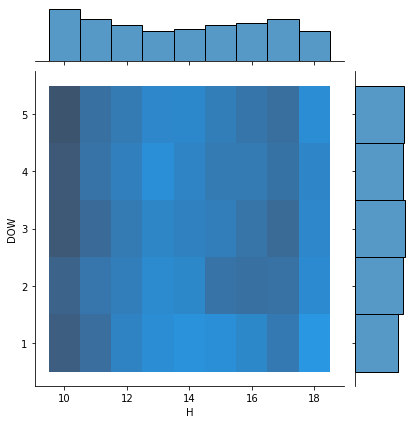

In [18]:
g = sns.JointGrid(data=data, x='H', y='DOW')
g.plot(sns.histplot, sns.histplot, discrete=(True, True))

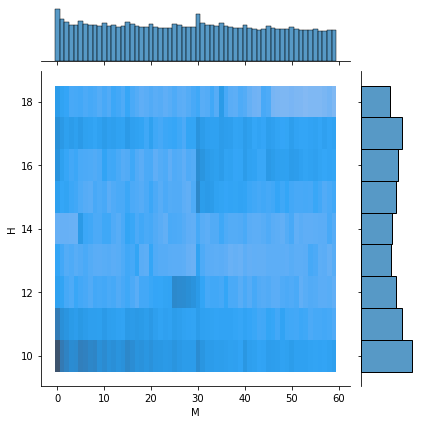

In [19]:
g = sns.JointGrid(data=data, x='M', y='H')
g.plot(sns.histplot, sns.histplot, discrete=(True, True))

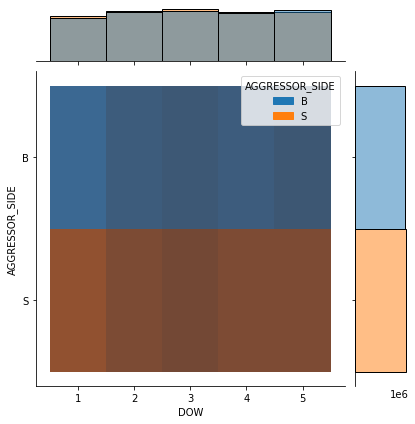

In [37]:
g = sns.JointGrid(data=data, x='DOW', y='AGGRESSOR_SIDE', hue='AGGRESSOR_SIDE')
g.plot(sns.histplot, sns.histplot, discrete=(True, True), stat='count')

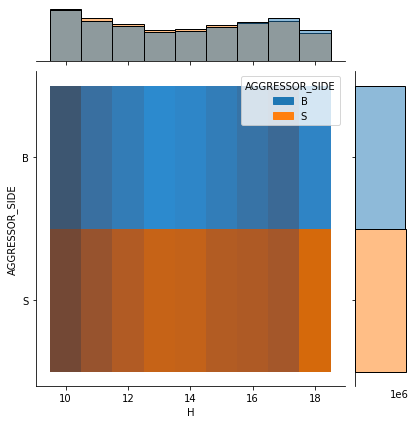

In [33]:
g = sns.JointGrid(data=data, x='H', y='AGGRESSOR_SIDE', hue='AGGRESSOR_SIDE')
g.plot(sns.histplot, sns.histplot, discrete=(True, True), stat='count')

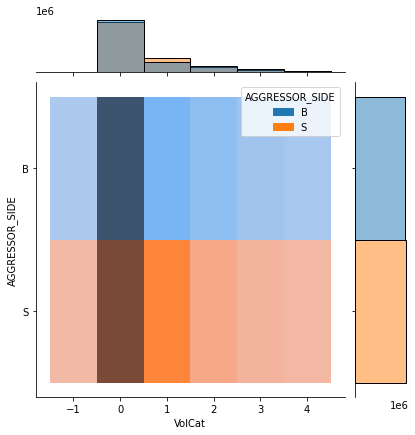

In [38]:
g = sns.JointGrid(data=data, x='VolCat', y='AGGRESSOR_SIDE', hue='AGGRESSOR_SIDE')
g.plot(sns.histplot, sns.histplot, discrete=(True, True), stat='count')

In [ ]:
orders_freq1s = market_orders[['Time', 'AGGRESSOR_SIDE']]
orders_freq1s_x50 = market_orders[market_orders['SIZE', 'sum'] %50 == 0][['Time', 'AGGRESSOR_SIDE']]
orders_freq1s_x100 = market_orders[market_orders['SIZE', 'sum'] %100 == 0][['Time', 'AGGRESSOR_SIDE']]

# Round Time column to sec
orders_freq1s.loc[:, 'Time'] = orders_freq1s['Time'].map(lambda d: dt.datetime(d.year, d.month, d.day, d.hour, d.minute, 0))
orders_freq1s_x50.loc[:, 'Time'] = orders_freq1s_x50['Time'].map(lambda d: dt.datetime(d.year, d.month, d.day, d.hour, d.minute, 0))
orders_freq1s_x100.loc[:, 'Time'] = orders_freq1s_x100['Time'].map(lambda d: dt.datetime(d.year, d.month, d.day, d.hour, d.minute, 0))

In [ ]:
orders_freq1s.loc[:, 'Count'] = 0
orders_freq1s_x50.loc[:, 'Count'] = 0
orders_freq1s_x100.loc[:, 'Count'] = 0

In [10]:
orders_freq1s = orders_freq1s.groupby(by=['Time','AGGRESSOR_SIDE'], as_index=False).count()
orders_freq1s_x50 = orders_freq1s_x50.groupby(by=['Time','AGGRESSOR_SIDE'], as_index=False).count()
orders_freq1s_x100 = orders_freq1s_x100.groupby(by=['Time','AGGRESSOR_SIDE'], as_index=False).count()

/home/sharpra/miniconda3/lib/python3.9/site-packages/pandas/core/generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [52]:
# DOW = {1: 'Mo', 2: 'Tu', 3: 'We', 4 :'Th', 5 :'Fr', 6: 'Sa', 7 :'Su'}

orders_freq1s['DoW'] = orders_freq1s['Time'].map(lambda d: d.isoweekday())
orders_freq1s_x50['DoW'] = orders_freq1s_x50['Time'].map(lambda d: d.isoweekday())
orders_freq1s_x100['DoW'] = orders_freq1s_x100['Time'].map(lambda d: d.isoweekday())

orders_freq1s['HOUR'] = orders_freq1s['Time'].map(lambda d: d.hour)
orders_freq1s_x50['HOUR'] = orders_freq1s_x50['Time'].map(lambda d: d.hour)
orders_freq1s_x100['HOUR'] = orders_freq1s_x100['Time'].map(lambda d: d.hour)

/home/sharpra/miniconda3/lib/python3.9/site-packages/pandas/core/generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/sharpra/miniconda3/lib/python3.9/site-packages/pandas/core/generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/sharpra/miniconda3/lib/python3.9/site-packages/pandas/core/generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


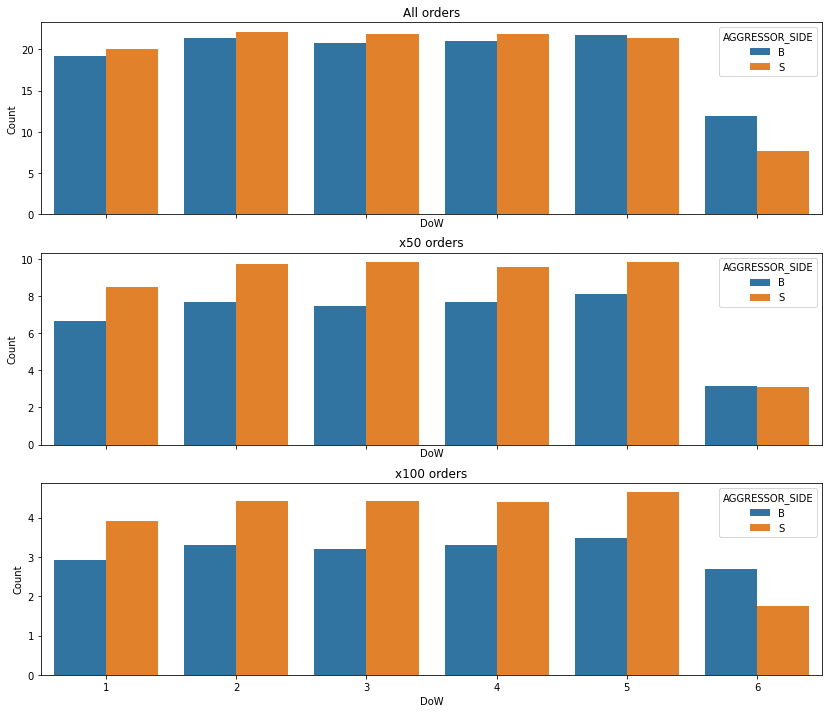

In [137]:
fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

filters = (orders_freq1s['DoW'] <= 6) & (orders_freq1s['HOUR'] >= 10) & (orders_freq1s['HOUR'] <= 17)
mean_dow = orders_freq1s[filters].groupby(by=['DoW', 'AGGRESSOR_SIDE'], as_index=False).mean()
sn.barplot(data=mean_dow, x='DoW', y='Count', hue='AGGRESSOR_SIDE', ax=axes[0])
axes[0].title.set_text('All orders')

filters = (orders_freq1s_x50['DoW'] <= 6) & (orders_freq1s_x50['HOUR'] >= 10) & (orders_freq1s_x50['HOUR'] <= 17)
mean_dow = orders_freq1s_x50[filters].groupby(by=['DoW', 'AGGRESSOR_SIDE'], as_index=False).mean()
sn.barplot(data=mean_dow, x='DoW', y='Count', hue='AGGRESSOR_SIDE', ax=axes[1])
axes[1].title.set_text('x50 orders')

filters = (orders_freq1s_x100['DoW'] <= 6) & (orders_freq1s_x100['HOUR'] >= 10) & (orders_freq1s_x100['HOUR'] <= 17)
mean_dow = orders_freq1s_x100[filters].groupby(by=['DoW', 'AGGRESSOR_SIDE'], as_index=False).mean()
sn.barplot(data=mean_dow, x='DoW', y='Count', hue='AGGRESSOR_SIDE', ax=axes[2])
axes[2].title.set_text('x100 orders')

<AxesSubplot:xlabel='DoW', ylabel='Count'>

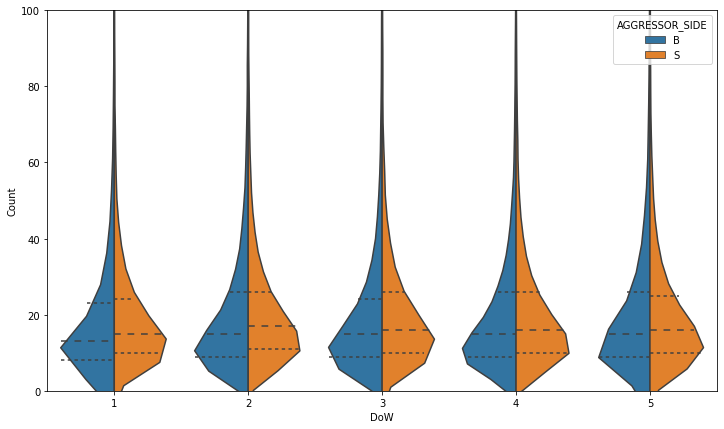

In [58]:
plt.figure(figsize=(12, 7))
plt.axes().set_ylim(top=100)

filters = (orders_freq1s['DoW'] < 6) & (orders_freq1s['HOUR'] >= 10) & (orders_freq1s['HOUR'] <= 17)
sn.violinplot(data=orders_freq1s[filters], x='DoW', y='Count', hue='AGGRESSOR_SIDE',
              split=True, inner='quart')

In [111]:
def print_ttest_matrix(data, hue, hue_range, side):
    print("\t".join([str(s) for s in hue_range]))
    
    for i in hue_range:
        for j in hue_range:
            x = data[filters & (data['AGGRESSOR_SIDE']==side) & (data[hue]==i)]['Count']
            y = data[filters & (data['AGGRESSOR_SIDE']==side) & (data[hue]==j)]['Count']

            print(f"{sts.ttest_ind(x, y, equal_var=False).pvalue:4.3f}", end='\t')
        print()

In [112]:
print('BUY')
print_ttest_matrix(orders_freq1s, 'DoW', range(1,6), 'B')
print()
print('SELL')
print_ttest_matrix(orders_freq1s, 'DoW', range(1,6), 'S')

BUY
1	2	3	4	5
1.000	0.000	0.000	0.000	0.000	
0.000	1.000	0.831	0.013	0.341	
0.000	0.831	1.000	0.009	0.477	
0.000	0.013	0.009	1.000	0.001	
0.000	0.341	0.477	0.001	1.000	

SELL
1	2	3	4	5
1.000	0.000	0.000	0.000	0.000	
0.000	1.000	0.700	0.001	0.001	
0.000	0.700	1.000	0.002	0.000	
0.000	0.001	0.002	1.000	0.000	
0.000	0.001	0.000	0.000	1.000	


<AxesSubplot:xlabel='DoW', ylabel='Count'>

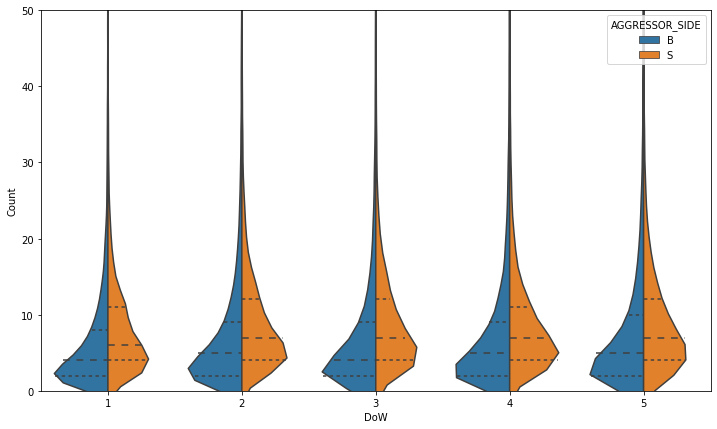

In [61]:
plt.figure(figsize=(12, 7))
plt.axes().set_ylim(top=50)

filters = (orders_freq1s_x50['DoW'] < 6) & (orders_freq1s_x50['HOUR'] >= 10) & (orders_freq1s_x50['HOUR'] <= 17)
sn.violinplot(data=orders_freq1s_x50[filters], x='DoW', y='Count', hue='AGGRESSOR_SIDE',
              split=True, inner='quart')

In [113]:
print('BUY')
print_ttest_matrix(orders_freq1s_x50, 'DoW', range(1,6), 'B')
print()
print('SELL')
print_ttest_matrix(orders_freq1s_x50, 'DoW', range(1,6), 'S')

BUY
1	2	3	4	5
1.000	0.000	0.000	0.000	0.000	
0.000	1.000	0.621	0.009	0.008	
0.000	0.621	1.000	0.034	0.030	
0.000	0.009	0.034	1.000	0.903	
0.000	0.008	0.030	0.903	1.000	

SELL
1	2	3	4	5
1.000	0.000	0.000	0.000	0.000	
0.000	1.000	0.752	0.279	0.058	
0.000	0.752	1.000	0.423	0.098	
0.000	0.279	0.423	1.000	0.384	
0.000	0.058	0.098	0.384	1.000	


<AxesSubplot:xlabel='DoW', ylabel='Count'>

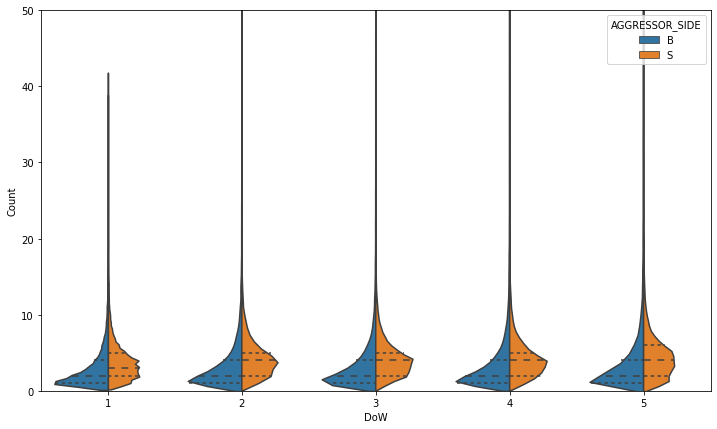

In [60]:
plt.figure(figsize=(12, 7))
plt.axes().set_ylim(top=50)

filters = (orders_freq1s_x100['DoW'] < 6) & (orders_freq1s_x100['HOUR'] >= 10) & (orders_freq1s_x100['HOUR'] <= 17)
sn.violinplot(data=orders_freq1s_x100[filters], x='DoW', y='Count', hue='AGGRESSOR_SIDE',
              split=True, inner='quart')

In [114]:
print('BUY')
print_ttest_matrix(orders_freq1s_x100, 'DoW', range(1,6), 'B')
print()
print('SELL')
print_ttest_matrix(orders_freq1s_x100, 'DoW', range(1,6), 'S')

BUY
1	2	3	4	5
1.000	0.000	0.000	0.000	0.000	
0.000	1.000	0.151	0.052	0.000	
0.000	0.151	1.000	0.001	0.000	
0.000	0.052	0.001	1.000	0.035	
0.000	0.000	0.000	0.035	1.000	

SELL
1	2	3	4	5
1.000	0.000	0.000	0.000	0.000	
0.000	1.000	0.797	0.262	0.000	
0.000	0.797	1.000	0.374	0.000	
0.000	0.262	0.374	1.000	0.000	
0.000	0.000	0.000	0.000	1.000	


/home/sharpra/miniconda3/lib/python3.9/site-packages/pandas/core/generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/sharpra/miniconda3/lib/python3.9/site-packages/pandas/core/generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/sharpra/miniconda3/lib/python3.9/site-packages/pandas/core/generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


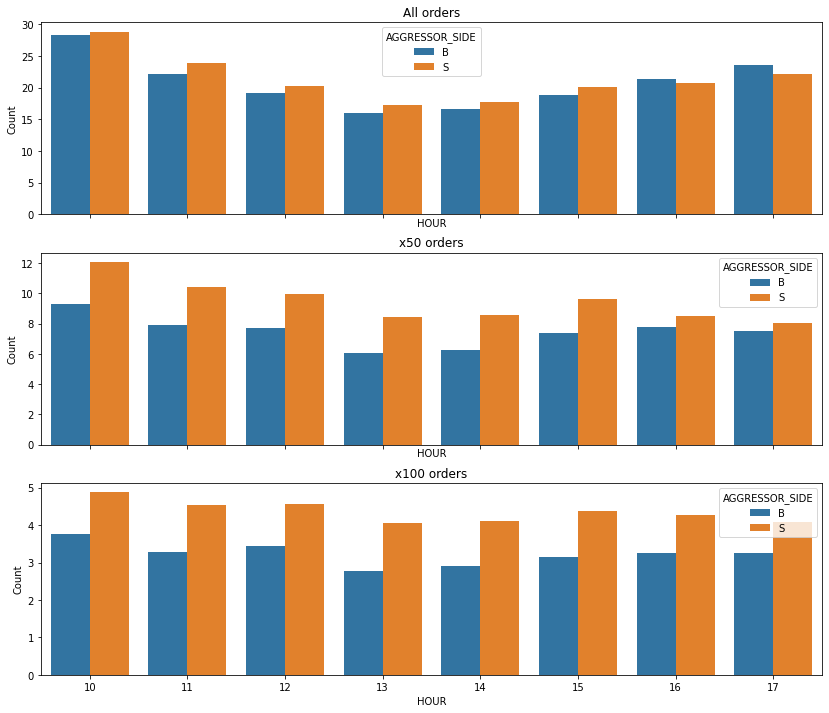

In [139]:
fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

filters = (orders_freq1s['DoW'] <= 6) & (orders_freq1s['HOUR'] >= 10) & (orders_freq1s['HOUR'] <= 17)
mean_dow = orders_freq1s[filters].groupby(by=['HOUR', 'AGGRESSOR_SIDE'], as_index=False).mean()
sn.barplot(data=mean_dow, x='HOUR', y='Count', hue='AGGRESSOR_SIDE', ax=axes[0])
axes[0].title.set_text('All orders')

filters = (orders_freq1s_x50['DoW'] <= 6) & (orders_freq1s_x50['HOUR'] >= 10) & (orders_freq1s_x50['HOUR'] <= 17)
mean_dow = orders_freq1s_x50[filters].groupby(by=['HOUR', 'AGGRESSOR_SIDE'], as_index=False).mean()
sn.barplot(data=mean_dow, x='HOUR', y='Count', hue='AGGRESSOR_SIDE', ax=axes[1])
axes[1].title.set_text('x50 orders')

filters = (orders_freq1s_x100['DoW'] <= 6) & (orders_freq1s_x100['HOUR'] >= 10) & (orders_freq1s_x100['HOUR'] <= 17)
mean_dow = orders_freq1s_x100[filters].groupby(by=['HOUR', 'AGGRESSOR_SIDE'], as_index=False).mean()
sn.barplot(data=mean_dow, x='HOUR', y='Count', hue='AGGRESSOR_SIDE', ax=axes[2])
axes[2].title.set_text('x100 orders')

<AxesSubplot:xlabel='HOUR', ylabel='Count'>

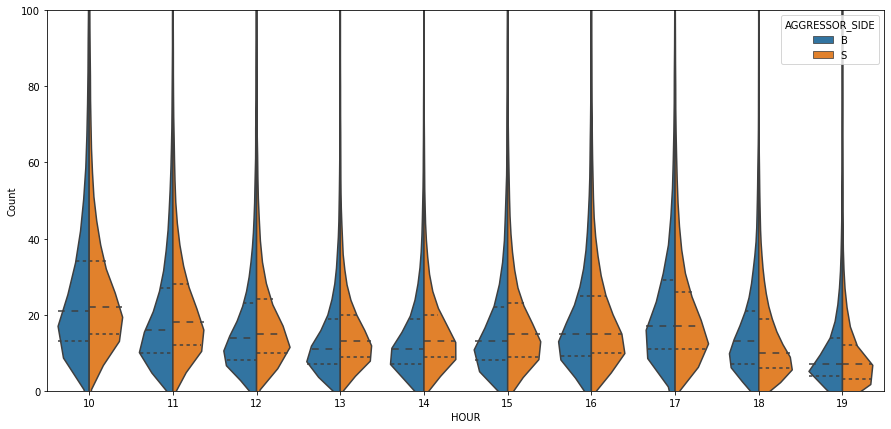

In [69]:
plt.figure(figsize=(15, 7))
plt.axes().set_ylim(top=100)

filters = (orders_freq1s['DoW'] < 6) & (orders_freq1s['HOUR'] >= 10) & (orders_freq1s['HOUR'] <= 19)
sn.violinplot(data=orders_freq1s[filters], x='HOUR', y='Count', hue='AGGRESSOR_SIDE',
              split=True, inner='quart')

In [118]:
print('BUY')
print_ttest_matrix(orders_freq1s, 'HOUR', range(10, 20), 'B')
print()
print('SELL')
print_ttest_matrix(orders_freq1s, 'HOUR', range(10, 20), 'S')

BUY
10	11	12	13	14	15	16	17	18	19
1.000	0.000	0.000	0.000	0.000	0.000	0.000	0.000	0.000	0.000	
0.000	1.000	0.000	0.000	0.000	0.000	0.000	0.173	0.000	0.000	
0.000	0.000	1.000	0.000	0.000	0.000	0.017	0.000	0.000	0.000	
0.000	0.000	0.000	1.000	0.000	0.000	0.000	0.000	0.000	0.000	
0.000	0.000	0.000	0.000	1.000	0.277	0.000	0.000	0.105	0.000	
0.000	0.000	0.000	0.000	0.277	1.000	0.000	0.000	0.596	0.000	
0.000	0.000	0.017	0.000	0.000	0.000	1.000	0.000	0.000	0.000	
0.000	0.173	0.000	0.000	0.000	0.000	0.000	1.000	0.000	0.000	
0.000	0.000	0.000	0.000	0.105	0.596	0.000	0.000	1.000	0.000	
0.000	0.000	0.000	0.000	0.000	0.000	0.000	0.000	0.000	1.000	

SELL
10	11	12	13	14	15	16	17	18	19
1.000	0.000	0.000	0.000	0.000	0.000	0.000	0.000	0.000	0.000	
0.000	1.000	0.000	0.000	0.000	0.000	0.000	0.527	0.000	0.000	
0.000	0.000	1.000	0.000	0.000	0.045	0.001	0.000	0.000	0.000	
0.000	0.000	0.000	1.000	0.035	0.000	0.000	0.000	0.230	0.000	
0.000	0.000	0.000	0.035	1.000	0.000	0.000	0.000	0.351	0.000	
0.000	0.000	0.0

<AxesSubplot:xlabel='HOUR', ylabel='Count'>

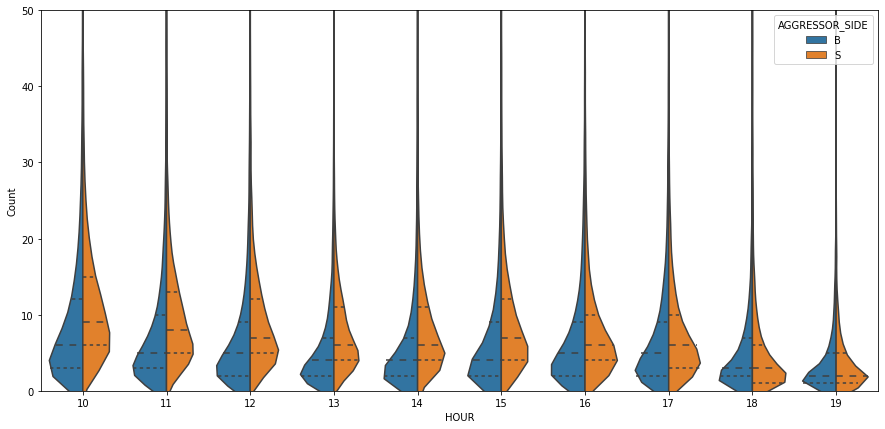

In [71]:
plt.figure(figsize=(15, 7))
plt.axes().set_ylim(top=50)

filters = (orders_freq1s_x50['DoW'] < 6) & (orders_freq1s_x50['HOUR'] >= 10) & (orders_freq1s_x50['HOUR'] <= 19)
sn.violinplot(data=orders_freq1s_x50[filters], x='HOUR', y='Count', hue='AGGRESSOR_SIDE',
              split=True, inner='quart')

In [120]:
print('BUY')
print_ttest_matrix(orders_freq1s_x50, 'HOUR', range(10, 20), 'B')
print()
print('SELL')
print_ttest_matrix(orders_freq1s_x50, 'HOUR', range(10, 20), 'S')

BUY
10	11	12	13	14	15	16	17	18	19
1.000	0.000	0.000	0.000	0.000	0.000	0.000	0.000	0.000	0.000	
0.000	1.000	0.234	0.000	0.000	0.003	0.005	0.000	0.000	0.000	
0.000	0.234	1.000	0.000	0.000	0.000	0.000	0.000	0.000	0.000	
0.000	0.000	0.000	1.000	0.003	0.000	0.000	0.000	0.000	0.000	
0.000	0.000	0.000	0.003	1.000	0.000	0.000	0.000	0.000	0.000	
0.000	0.003	0.000	0.000	0.000	1.000	0.716	0.774	0.000	0.000	
0.000	0.005	0.000	0.000	0.000	0.716	1.000	0.493	0.000	0.000	
0.000	0.000	0.000	0.000	0.000	0.774	0.493	1.000	0.000	0.000	
0.000	0.000	0.000	0.000	0.000	0.000	0.000	0.000	1.000	0.000	
0.000	0.000	0.000	0.000	0.000	0.000	0.000	0.000	0.000	1.000	

SELL
10	11	12	13	14	15	16	17	18	19
1.000	0.000	0.000	0.000	0.000	0.000	0.000	0.000	0.000	0.000	
0.000	1.000	0.155	0.000	0.000	0.000	0.000	0.000	0.000	0.000	
0.000	0.155	1.000	0.000	0.000	0.008	0.016	0.000	0.000	0.000	
0.000	0.000	0.000	1.000	0.070	0.000	0.000	0.000	0.000	0.000	
0.000	0.000	0.000	0.070	1.000	0.000	0.000	0.000	0.000	0.000	
0.000	0.000	0.0

<AxesSubplot:xlabel='HOUR', ylabel='Count'>

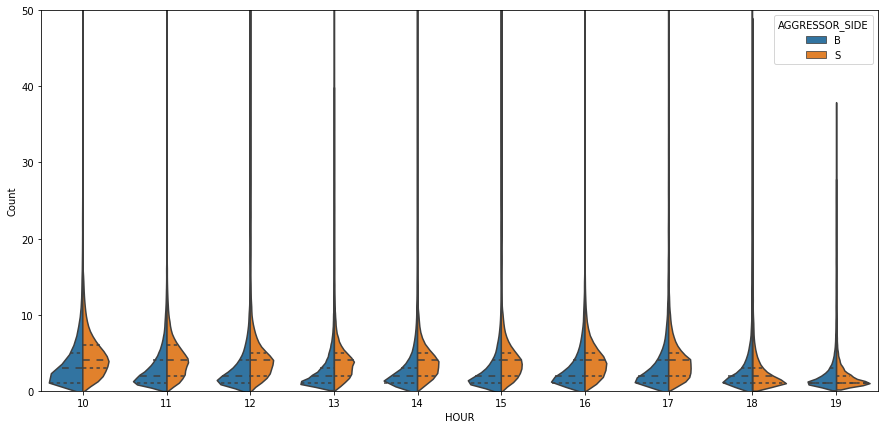

In [82]:
plt.figure(figsize=(15, 7))
plt.axes().set_ylim(top=50)

filters = (orders_freq1s_x100['DoW'] < 6) & (orders_freq1s_x100['HOUR'] >= 10) & (orders_freq1s_x100['HOUR'] <= 19)
sn.violinplot(data=orders_freq1s_x100[filters], x='HOUR', y='Count', hue='AGGRESSOR_SIDE',
              split=True, inner='quart')

In [119]:
print('BUY')
print_ttest_matrix(orders_freq1s_x100, 'HOUR', range(10, 20), 'B')
print()
print('SELL')
print_ttest_matrix(orders_freq1s_x100, 'HOUR', range(10, 20), 'S')

BUY
10	11	12	13	14	15	16	17	18	19
1.000	0.000	0.000	0.000	0.000	0.000	0.000	0.000	0.000	0.000	
0.000	1.000	0.012	0.000	0.000	0.008	0.423	0.597	0.000	0.000	
0.000	0.012	1.000	0.000	0.000	0.000	0.002	0.006	0.000	0.000	
0.000	0.000	0.000	1.000	0.009	0.000	0.000	0.000	0.625	0.000	
0.000	0.000	0.000	0.009	1.000	0.000	0.000	0.000	0.007	0.000	
0.000	0.008	0.000	0.000	0.000	1.000	0.083	0.050	0.000	0.000	
0.000	0.423	0.002	0.000	0.000	0.083	1.000	0.808	0.000	0.000	
0.000	0.597	0.006	0.000	0.000	0.050	0.808	1.000	0.000	0.000	
0.000	0.000	0.000	0.625	0.007	0.000	0.000	0.000	1.000	0.000	
0.000	0.000	0.000	0.000	0.000	0.000	0.000	0.000	0.000	1.000	

SELL
10	11	12	13	14	15	16	17	18	19
1.000	0.000	0.000	0.000	0.000	0.000	0.000	0.000	0.000	0.000	
0.000	1.000	0.477	0.000	0.000	0.001	0.000	0.000	0.000	0.000	
0.000	0.477	1.000	0.000	0.000	0.000	0.000	0.000	0.000	0.000	
0.000	0.000	0.000	1.000	0.250	0.000	0.000	0.592	0.000	0.000	
0.000	0.000	0.000	0.250	1.000	0.000	0.001	0.559	0.000	0.000	
0.000	0.001	0.0

<AxesSubplot:xlabel='Count', ylabel='Percent'>

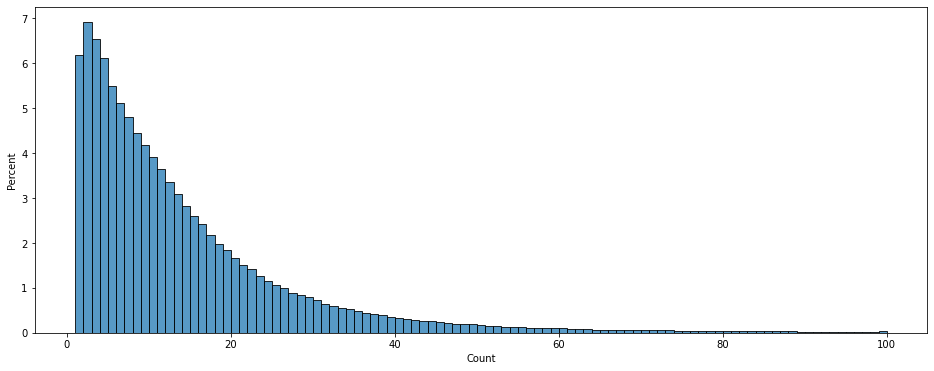

In [80]:
plt.figure(figsize = (16, 6))
sn.histplot(data=orders_freq1s[(orders_freq1s['Count'] <= 100)], x='Count', 
            binwidth=1, multiple='dodge', stat='percent')

<AxesSubplot:xlabel='Count', ylabel='Percent'>

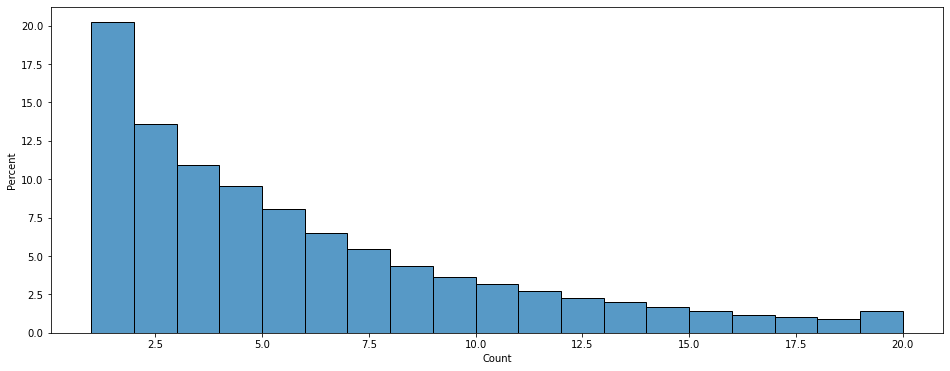

In [81]:
plt.figure(figsize = (16, 6))
sn.histplot(data=orders_freq1s_x50[(orders_freq1s_x50['Count'] <= 20)], x='Count', 
            binwidth=1, multiple='dodge', stat='percent')

<AxesSubplot:xlabel='Count', ylabel='Percent'>

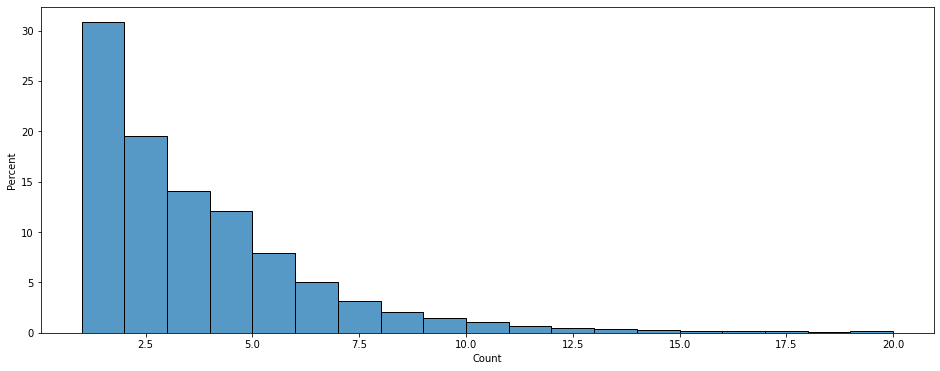

In [77]:
plt.figure(figsize = (16, 6))
sn.histplot(data=orders_freq1s_x100[(orders_freq1s_x100['Count'] <= 20)], x='Count', 
            binwidth=1, multiple='dodge', stat='percent')